In [1]:
__author__ = 'Knut Olsen <kolsen@noao.edu>' # single string; emails in <>
__version__ = '20200824' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr1,smash_dr1']  # enter used datasets by hand
__keywords__ = ['tutorial','query','image cutout','SIA']

# Welcome to the NOIRLab ASTRO Data Lab
*Knut Olsen, NOIRLab ASTRO Data Lab Team*

## Table of contents
* [Goals](#goals)
* [Summary](#summary)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [Basic info about database tables](#basic)
* [A simple database query](#query)
* [An image cutout](#image)

<a class="anchor" id="goals"></a>
# Goals
Learn how to:
* Import standard Data Lab modules
* Set up the Simple Image Access (SIA) Service to let you create image cutouts
* Discover the datasets available in the database
* Issue a simple query to the database
* Retrieve image cutouts
* Create a color image


<a class="anchor" id="summary"></a>
# Summary

If you've gotten this far, you're planning to use the Data Lab Jupyter notebook environment to access, explore, and analyze datasets available in the Data Lab.  This notebook aims to provide you with a very quick overview of how to use some common Data Lab services.  For more detailed explanations of data access, the full range of services, or for complete science examples, check out the other notebooks in this directory tree.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/disclaimers.php


<a class="anchor" id="import"></a>
# Imports and setup
To use the Data Lab, you'll generally want to import common packages such as NumPy and matplotlib.  From the datalab package, you'll at minimum need the authClient module to get an authorization token (even if using Data Lab anonymously) and the queryClient module to issue a query against the catalog database.

For storing results in virtual storage and myDB, you'll need the storeClient module *and* log in as an authenticated user.  

The helpers module has many convenient functions.  See the <a href="http://datalab.noao.edu/docs/manual/UsingTheNOAODataLab/ClientInterfaces/Helpers/Helpers.html">online documentation</a> for a summary.

Use of the image cutout service (SIA) requires the external PyVO package, and the URL of the SIA service that you will use.  Data Lab has a general SIA service containing all available images from NOAO Science Archive, as well as a number of survey-specific services.  See the SIA service HowTo for examples.

In [34]:
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io
from getpass import getpass
from astropy.visualization import make_lupton_rgb

%matplotlib inline

# Datalab and related imports
# You'll need at least these for authenticating and for issuing database queries
from dl import authClient as ac, queryClient as qc
# You'll want storeClient if you plan to use virtual storage or myDB
#from dl import storeClient as sc
# Get helpers for various convenience function
from dl.helpers.utils import convert

# To get image cutouts, you'll need the VO-based SIA package, and define which SIA service
# to use
from pyvo.dal import sia
DEF_ACCESS_URL = "https://datalab.noao.edu/sia/des_dr1" # DES SIA service URL
svc = sia.SIAService(DEF_ACCESS_URL)

<a class="anchor" id="auth"></a>
# Authentication
For the purposes of this notebook, there is no need to log in with your username and password inside the notebook. As an anonymous user, you can issue queries to the database or retrieve image cutouts, but not store your results in virtual storage or myDB.  If you need these things, you would use the *authClient* module to log in.  You only need to do this once (unless you log out through authClient), as the authentication token is stored on the server and automatically detected. 

In [12]:
#ac.login(input("Enter user name: "),getpass("Enter password: "))
ac.whoAmI()

'ajacques'

<a class="anchor" id="basic"></a>
# Basic info about database tables

### What datasets are available?
The queryClient has a <tt>schema</tt> method to give you information about available databases, tables, and columns.  If we call <tt>qc.schema()</tt> with an empty first argument, we'll get information on the available datasets and a one-line description for most of them.

In [3]:
print(qc.schema())


     Schema Name   Description
     -----------   -----------
         allwise   The AllWISE data release
         dad_dr1   DECam Asteroid Database -- Data Release 1
         dad_dr2   DECam Asteroid Database -- Data Release 2
      decaps_dr1   DECam Plane Survey Data Release 1
      delve_y2t1   
         des_dr1   Dark Energy Survey (DES) Data Release 1
        des_sva1   DES SVA1 Data Products
        gaia_dr1   GAIA Data Release 1
        gaia_dr2   Gaia Data Release 2 -- April 25, 2018
     gogreen_dr1   GOGREEN and GCLASS first data release survey catalogues
       hipparcos   ftp://cdsarc.u-strasbg.fr/pub/cats/I/239/ReadMe
      hipparcos2   A new reduction of the astrometric data as produced by the
                   Hipparcos mission has been published, claiming accuracies
                   for nearly all stars brighter than magnitude Hp=8 to be b
                   etter, by up to a factor 4, than in the original catalogue
                   . ftp://cdsarc.u-strasbg.fr/pu

### Get list of tables
If we call qc.schema() with a specific dataset name, we'll see what tables are available for that dataset.  Here's what's available for SMASH DR1:

In [3]:
print(qc.schema('smash_dr1'))


Schema: smash_dr1

      Table Name   Description
      ----------   -----------
            chip   Info on each chip in the frame
        exposure   Info on each exposure
           field   Info on each target field (position, Num exposures, etc)
        galaxies   View of object table to select for galaxies
          object   Average photometry of each unique object
          source   All of the individual source measurements
           stars   View of object table to select for stars
          xmatch   Crossmatch of object against GAIA DR1 and WISE



### Get list of columns
We can also use qc.schema() to get column names and descriptions for a specific table.  Here's what's available for the SMASH DR1 object table.  (Note that not all datasets have column descriptions for every column).

In [23]:
print(qc.schema('smash_dr1.object'))


Schema: smash_dr1
 Table: object

     Column Name   Description
     -----------   -----------
              id   Unique ID for this object, the field name plus a running number
         fieldid   SMASH Field ID
              ra   Right Ascension (J2000.0) of source, in degrees
             dec   Declination (J2000.0) of source, in degrees
            glon   Galactic Longitude
            glat   Galactic Latitude
            elon   Ecliptic Longitude
            elat   Ecliptic Latitude
            htm9   HTM index (order 9 => ~10 arcmin size)
         ring256   HEALPIX index (Nsides 256, Ring scheme => ~14 arcmin size)
        nest4096   HEALPIX index (Nsides 4096, Nest scheme => ~52 arcsec size
       random_id   Random ID in the range 0.0 => 100.0
           raerr   Uncertainty in mean RA of object (arcseconds) from indiv values
          decerr   Uncertainty in mean DEC of object (arcseconds) from indiv 
                   values
            ndet   Number of detections of this so

### Getting statistics for tables
You'll often want to get some basic information about a given table, e.g. the number of rows.  You might be tempted to use COUNT(\*) in a query for this--DON'T DO THIS.  You'll be scanning the entire table, which for some tables will mean scanning billions of rows.  Instead, the special database <tt>tbl_stat</tt> contains this information for each dataset.  Query this table instead:

In [4]:
#query="SELECT COUNT(ra) FROM phat_v2.phot_mod" # SLOW
query="SELECT * FROM tbl_stat WHERE schema='smash_dr1' and tbl_name='object'" # Retrieve useful stats, quickly

In [5]:
%time
info = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 10.3 µs


In [6]:
print(info)

schema,tbl_name,nrows,ncols,nindex,table_size,indexes_size,total_size
smash_dr1,object,418632416,45,23,91 GB,186 GB,277 GB



<a class="anchor" id="query"></a>
# A simple query
In the above section you already saw a basic query of the <tt>tbl_stats</tt> database.  Here we will retrieve the first 10 rows from the <tt>smash_dr1.object</tt> table:

In [7]:
%time
query="SELECT * FROM smash_dr1.object LIMIT 10"
result = qc.query(sql=query) # by default the result is a CSV formatted string

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.68 µs


You'll notice that the result is returned as a long string:

In [8]:
print(type(result))
print(result[0:99]) # print the first 100 characters

<class 'str'>
ra,dec,glon,glat,elon,elat,htm9,ring256,nest4096,random_id,raerr,decerr,umag,uerr,uscatter,gmag,ger


You'll generally want to convert this string into a table or an array.  The <tt>helpers</tt> module makes it easy.  Here we convert the string result into a Pandas dataframe:

In [9]:
df = convert(result,'pandas')
df.head()

,ra,dec,glon,glat,elon,elat,htm9,ring256,nest4096,random_id,...,ndet,depthflag,ndetu,ndetg,ndetr,ndeti,ndetz,flag,fieldid,id
0,103.068355,-37.973539,247.782969,-16.141355,111.190624,-60.455055,2590841,634661,162297226,89.515400,...,1,1,0,1,0,0,0,-1,153,153.163302
1,103.071774,-37.973599,247.784083,-16.138880,111.196021,-60.454623,2590841,634661,162297224,59.119800,...,1,1,0,1,0,0,0,-1,153,153.163302
2,103.071598,-37.972329,247.782804,-16.138531,111.195274,-60.453399,2590841,634661,162297224,52.134600,...,1,1,0,1,0,0,0,-1,153,153.163299
3,103.082522,-37.972303,247.786153,-16.130543,111.212433,-60.451802,2590841,634661,162297225,0.839271,...,1,1,1,0,0,0,0,-1,153,153.175147
4,103.083560,-37.972606,247.786766,-16.129898,111.214178,-60.451950,2590841,634661,162297225,54.653200,...,1,1,1,0,0,0,0,-1,153,153.175148


You could store these results to VOSpace or to mydb if you logged in as an authenticated user.  See the HowTo notebooks for examples of this.

<a class="anchor" id="image"></a>
# An image cutout
Using the image cutout service is a two-step process.  First, you need to specify a position (ra/dec in degrees) and the size of the image (fov in degrees) that you want to retrieve, and then call the SIA service for all of the images that overlap that point on the sky. 

**REMINDER:** the following example retrieves from the des_dr1 database. In order to retrieve an image cutout from a different database you must change the last part of the SIA service URL in the [imports cell](#import). For a full list of the available databases that work with SIA, please see the How_to_use_the_Simple_Image_Access_service.ipynb notebook in the HowTo folder.

In [44]:
ra = 35.
dec = -52.
fov = 1./60 # arcmin to degrees
#fov = 0.1
imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

The result is a VOTable that we convert to an astropy Table on the fly.  The table contains many columns of data describing the parameters of each image, including a URL for the cutout itself.  Note, however, that data quality images such as masks or weight maps can also appear in the list:

In [45]:
print(type(imgTable))
imgTable

<class 'astropy.table.table.Table'>


assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,bytes1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666",image/fits,86526,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noao/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0218-5205_r2577p01_det.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666&preview=true",,,34.6984,-52.0957,--,,,--,-2.98156e-39,2.98156e-39,--,--,--,--,--,--,,,,DES0218-5205,0,DES DR1,30,image,0,0,,1710,,Stack,,556580.19824569,0
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=2&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666",image/fits,86526,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noao/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0218-5205_r2577p01_det.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=2&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666&preview=true",,,34.6984,-52.0957,--,,,--,-3.13891e-43,3.13891e-43,--,--,--,--,--,--,,,,DES0218-5205,0,DES DR1,30,mask,0,0,,1710,,Stack,,556580.19824569,0
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=3&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666",image/fits,86526,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,,,,ivo://datalab.noao/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0218-5205_r2577p01_det.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_det.fits.fz&extn=3&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666&preview=true",,,34.6984,-52.0957,--,,,--,-2.7656e-41,2.7656e-41,--,--,--,--,--,--,,,,DES0218-5205,0,DES DR1,30,weight,0,0,,1710,,Stack,,556580.19824569,0
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666",image/fits,164905,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0218-5205_r2577p01_g.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666&preview=true",,,34.6984,-52.0957,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES0218-5205,0,DES DR1,30,image,0,0,,540,,Stack,,556579.36250174,0
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=2&POS=35.0,-52.0&SIZE=0.

The next step is to identify the image that you want from the list of available images.  Here we will limit the list to g-band image Stacks, and select the <tt>image</tt> product type (rather than weights or masks).

In [46]:
sel0 = imgTable['obs_bandpass'].astype(str)=='g'
# basic selection:
sel = sel0 & ((imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image'))
Table = imgTable[sel] # select
Table

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,bytes1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr1,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666",image/fits,164905,,,2,0,0,2,[10000 10000],,,[0.27],,des_dr1,,DES DR1,archival,,,DECam,g,,,ivo://datalab.noao/vo#ivoa_des_dr1.siav1:ivo://datalab.noao/des_dr1/DES0218-5205_r2577p01_g.fits.fz,,"https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666&preview=true",,,34.6984,-52.0957,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,DES0218-5205,0,DES DR1,30,image,0,0,,540,,Stack,,556579.36250174,0


The final step is to extract the URL and download the image:

In [47]:
row = Table[0] # access the first entry
url = row['access_url'].decode() # get the download URL
print(url)

https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_g.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666


In [48]:
gimage = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

We'll do a quick display here:

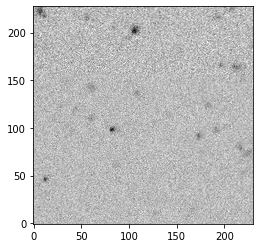

In [49]:
plt.imshow(gimage,cmap=matplotlib.cm.gray_r,origin='lower')

### Want to make a color image?
Let's write a quick function to do the SIA query and download, download two more bands, and combine them with the g image.

In [51]:
# a little function to download the deepest stacked images
# adapted from R. Nikutta
def download_deep_stack(ra,dec,fov,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()
    print('The full image list for', band, 'band contains', len(imgTable), 'entries')
    
    sel0 = imgTable['obs_bandpass'].astype(str)==band
    # basic selection:
    sel = sel0 & ((imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image'))
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'].decode() # get the download URL
        print('downloading deepest stacked image for', band, 'band...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))
        print(url)
        
    else:
        print ('No image available.')
        image=None
        
    return image

In [52]:
rimage = download_deep_stack(ra,dec,fov,band='r')
iimage = download_deep_stack(ra,dec,fov,band='i')

The full image list for r band contains 18 entries
downloading deepest stacked image for r band...
https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_r.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666
The full image list for i band contains 18 entries
downloading deepest stacked image for i band...
https://datalab.noao.edu/svc/cutout?col=des_dr1&siaRef=DES0218-5205_r2577p01_i.fits.fz&extn=1&POS=35.0,-52.0&SIZE=0.027071154091379068,0.016666666666666666


The following function by Astropy returns an RGB color image from up to 3 images using an asinh stretch. The input images can be int or float, and in any range or bit-depth.

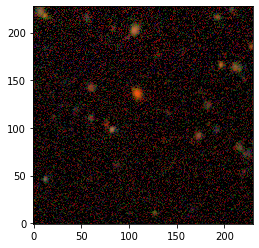

In [56]:
color_image = make_lupton_rgb(iimage, rimage, gimage, stretch=30)
plt.imshow(color_image,origin='lower')